In [1]:
from headers_constants import *
from Cell_cib import *
from Cell_tSZ import *
from Cell_CIBxtSZ import *
from plot_cell import *

Although we are calculating the halo mass function, halo bias, and the
Fourier transform of the NFW profile here, the computation can be speeded up
by precomputing them before and storing them in a file and then reading
them here.

In [2]:
deltah_cib = 200
hdulist = fits.open('data_files/filtered_snu_planck.fits')
redshifts = hdulist[1].data
snu_eff_pl = hdulist[0].data  # in Jy/Lsun
hdulist.close()

cc_pl = np.array([1.076, 1.017, 1.119, 1.097, 1.068, 0.995, 0.960])
# [100, 143, 217, 353, 545, 857, 3000] GHz
fc_pl = np.ones(len(cc_pl))

z_c = 1.5
Meffmax, etamax, sigmaMh = 8753289339381.791, 0.4028353504978569, 1.807080723258688
tau = 1.2040244128818796

The effective SEDs for the CIB for Planck (100, 143, 217, 353, 545, 857) and
IRAS (3000) GHz frequencies.
Here we are shwoing the CIB power spectra corressponding to the Planck
frequency channels. If you want to calculate the Hershel/Spire
power spectra, use corresponding files in the data folder.

In [3]:
ll = [str(x) for x in range(1, 211)]
addr = 'data_files/matter_power_spectra'
pkarray = np.loadtxt('%s/test_highk_lin_matterpower_210.dat' % (addr))
k = pkarray[:, 0]*cosmo.h
Pk = np.zeros((len(k), len(redshifts)))
for i in range(len(redshifts)):
    pkarray = np.loadtxt("%s/test_highk_lin_matterpower_%s.dat" % (addr, ll[209-i]))
    Pk[:, i] = pkarray[:, 1]/cosmo.h**3

ell = np.linspace(150., 2000., 20)

z = redshifts

k_array = np.zeros((len(ell), len(z)))
Pk_int = np.zeros((len(ell), len(z)))

for i in range(len(ell)):
    k_array[i, :] = ell[i]/(cosmo.comoving_distance(z).value)
    for j in range(len(z)):
        Pk_int[i, j] = np.interp(k_array[i, j], k, Pk[:, j])

logmass = np.arange(6, 15.005, 0.1)
mass = 10**logmass


nm = len(mass)
nz = len(z)

In [4]:
hmf = np.zeros((nm, nz))
u_nfw = np.zeros((nm, len(k_array[:, 0]), nz))
bias_m_z = np.zeros((nm, nz))
delta_h = deltah_cib

for r in range(nz):
    instance = hmf_unfw_bias.h_u_b(k, Pk[:, r], z[r],
                                   cosmo, delta_h, mass)
    hmf[:, r] = instance.dn_dlogm()
    # nfw_u[:, :, r] = instance.nfwfourier_u()
    bias_m_z[:, r] = instance.b_nu()
    instance2 = hmf_unfw_bias.h_u_b(k_array[:, r],
                                    Pk_int[:, r], z[r],
                                    cosmo, delta_h, mass)
    u_nfw[:, :, r] = instance2.nfwfourier_u()

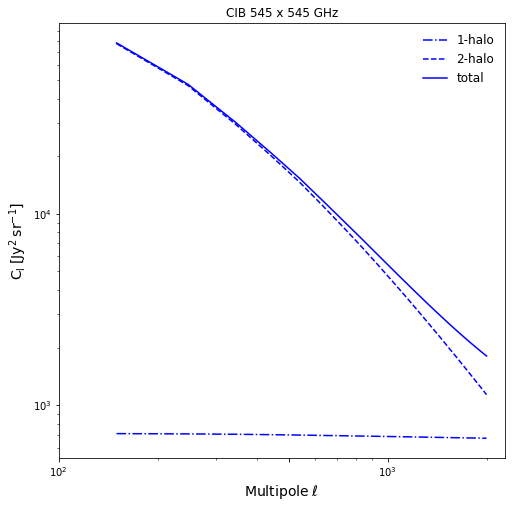

In [5]:
clcib = cl_cib(k_array, Pk_int, z, z_c, mass,
               snu_eff_pl, ell,
               cosmo, Meffmax, etamax, sigmaMh,
               tau, cc_pl, fc_pl, hmf, u_nfw, bias_m_z)
cl1h_cib = clcib.onehalo_int()
cl2h_cib = clcib.twohalo_int()

# plotting the CIB power spectra for freq[nu1]xfreq[nu2] GHz
freq = ['100', '143', '217', '353', '545', '857']
nu1, nu2 = 4, 4
plot_Cell(ell, cl1h_cib, cl2h_cib, nu1, nu2, freq, 'CIB')

In [6]:
xstep = 50
lnx = np.linspace(-6, 1, xstep)
x = 10**lnx
nu = np.array([100., 143., 217., 353., 545., 857.])*ghz
nus = ['100', '143', '217', '353', '545', '857']
delta_h_tsz = 500
B = 1.41
m500 = np.repeat(mass[..., np.newaxis], len(z), axis=1)

bias_m_z = np.zeros((len(m500[:, 0]), len(z)))
for r in range(len(z)):
    instance2 = hmf_unfw_bias.h_u_b(k,
                                    Pk[:, r], z[r],
                                    cosmo, delta_h_tsz, m500[:, 0])
    bias = instance2.b_nu()
    bias_m_z[:, r] = bias
# """

hmf = np.zeros((len(m500), len(z)))
for r in range(len(z)):
    test_filt = hmf_unfw_bias.h_u_b(k,
                                    Pk[:, r], z[r],
                                    cosmo, delta_h_tsz, m500[:, 0])
    hmf[:, r] = test_filt.dn_dlogm()
    instance2 = hmf_unfw_bias.h_u_b(k_array[:, r],
                                    Pk_int[:, r], z[r],
                                    cosmo, delta_h_tsz, mass)
    u_nfw[:, :, r] = instance2.nfwfourier_u()

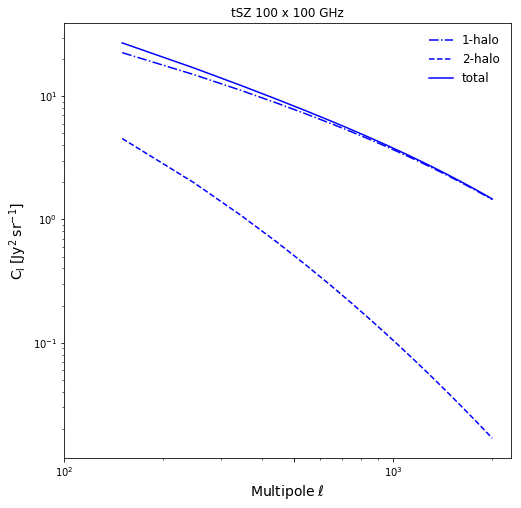

In [7]:
cltsz = cl_tsz(nu, m500, z, cosmo, delta_h_tsz, x, ell, B, hmf, Pk_int,
               bias_m_z)
cl1h_tsz = cltsz.C_ell_1h()
cl2h_tsz = cltsz.C_ell_2h()

# plotting the tSZ power spectra for freq[nu1]xfreq[nu2] GHz
freq = ['100', '143', '217', '353', '545', '857']
nu1, nu2 = 0, 0
plot_Cell(ell, cl1h_tsz, cl2h_tsz, nu1, nu2, freq, 'tSZ')

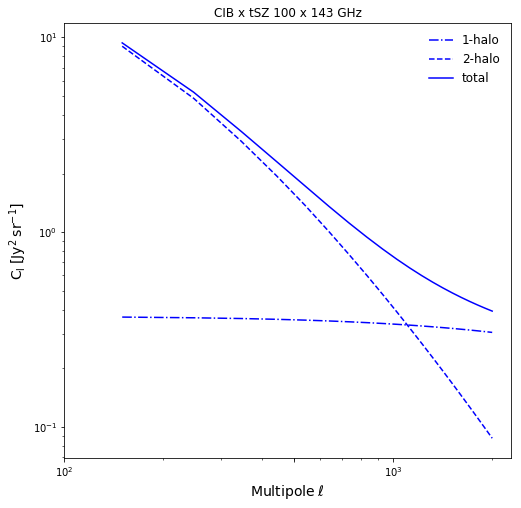

In [8]:
Meffmax, etamax, sigmaMh = 6962523672799.227, 0.4967291547804018, 1.8074450009861387
tau = 1.2016980179374213
cib_cls = cl_cib(k_array, Pk_int, z, z_c, mass,
                 snu_eff_pl[:-1, :], ell,
                 cosmo, Meffmax, etamax, sigmaMh,
                 tau, cc_pl[:-1], fc_pl[:-1], hmf, u_nfw, bias_m_z)
tsz_cls = cl_tsz(nu, m500, z, cosmo, delta_h_tsz, x, ell, B, hmf, Pk_int,
                 bias_m_z)
cibtsz = cl_cibxtsz(cib_cls, tsz_cls)
cl1h_cibtsz = cibtsz.onehalo()  # *Kcmb_MJy*1e6
cl2h_cibtsz = cibtsz.twohalo()

# plotting the CIBxtSZ power spectra for freq[nu1]xfreq[nu2] GHz
freq = ['100', '143', '217', '353', '545', '857']
nu1, nu2 = 0, 1
plot_Cell(ell, cl1h_cibtsz, cl2h_cibtsz, nu1, nu2, freq, 'CIB x tSZ')